**Import Libraries**

In [1]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

2025-05-18 18:50:52.142568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747574452.841694    5023 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747574453.018439    5023 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747574454.620821    5023 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747574454.620884    5023 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747574454.620887    5023 computation_placer.cc:177] computation placer alr

**Load Data**

In [2]:

folder_path = 'class/3-class'

def map_filename_to_label(name):
    name_low = name.casefold()
    if "yukar" in name_low:
        return "up"
    elif "asagi" in name_low:
        return "down"
    elif "sag" in name_low:
        return "right"
    elif "sol" in name_low:
        return "left"
    elif "kirp" in name_low:
        return "blink"
    else:
        return None

files = [f for f in glob.glob(folder_path + '/*.txt') 
         if all(x not in f.lower() for x in ['örnek', 'edit', 'serkan', 'kayit'])]

data_list = []
labels = []

for f in files:
    label = map_filename_to_label(f)
    if label is None:
        continue
    signal = np.loadtxt(f)
    if len(signal.shape) > 1:
        signal = signal.flatten()
    data_list.append(signal)
    labels.append(label)

data_array = np.array(data_list)
labels = np.array(labels)
print(f"Loaded {len(data_array)} signals with labels: {set(labels)}")

Loaded 223 signals with labels: {'down', 'right', 'blink', 'up', 'left'}


**Plotting One Sample Signal Per Class**

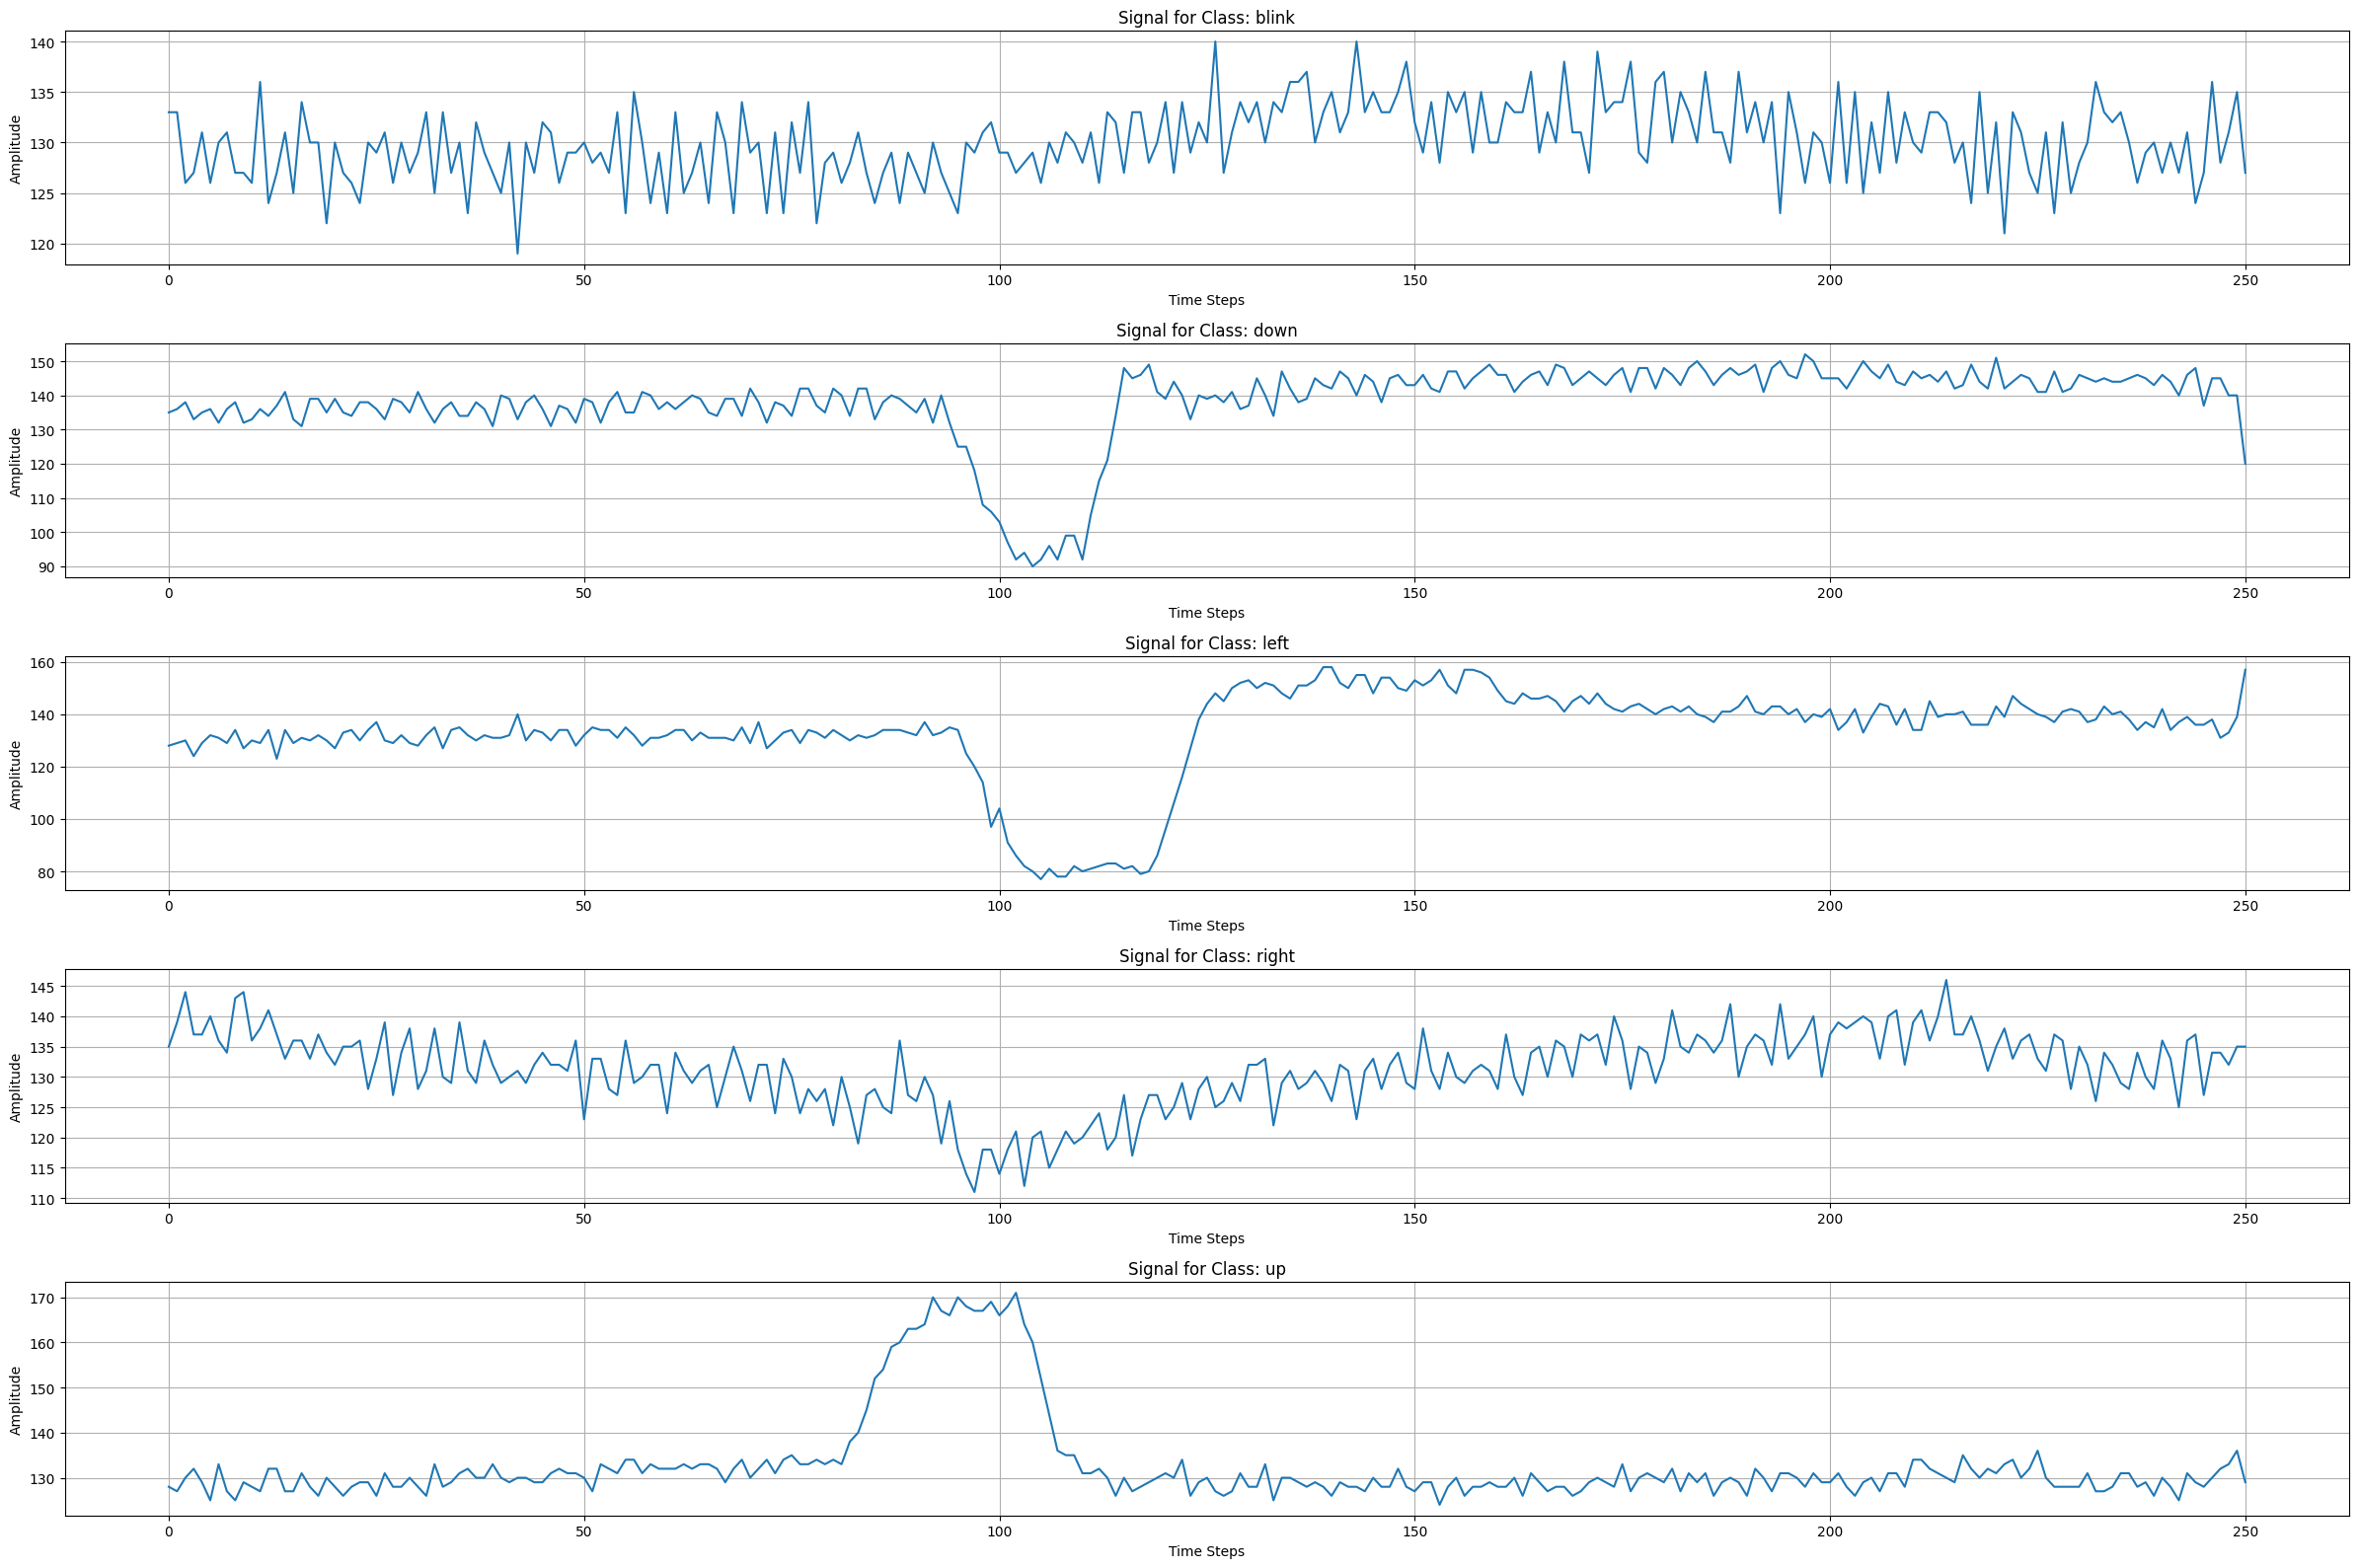

In [3]:
unique_labels = np.unique(labels)
plt.figure(figsize=(24, 16))  # Adjust figure size as needed

for i, label in enumerate(unique_labels):
    # Find the first occurrence of the label
    index = np.where(labels == label)[0][0]
    signal = data_array[index]

    plt.subplot(len(unique_labels), 1, i + 1)  # Create subplots for each class
    plt.plot(signal)
    plt.title(f"Signal for Class: {label}")
    plt.xlabel("Time Steps")  # Add x-axis label
    plt.ylabel("Amplitude")  # Add y-axis label
    plt.grid(True)  # Add gridlines for better readability

plt.tight_layout()  
plt.show()

**Data Augumentation**

In [4]:

# --- Data Augmentation
def augment_signal(signal):
    noise = np.random.normal(0, 0.03, signal.shape)
    scale = np.random.uniform(0.98, 1.02)
    return (signal * scale) + noise

def add_instance_noise(signal, stddev=0.02):
    return signal + np.random.normal(0, stddev, signal.shape)

**Balanced the Data**

In [5]:
from collections import Counter
from sklearn.utils import resample

# Augment and balance raw signals (as before)
augmented_data_list = []
augmented_labels_list = []
unique_labels = np.unique(labels)
class_counts = Counter(labels)
max_count = max(class_counts.values())

for label in unique_labels:
    class_signals = [sig for sig, lab in zip(data_list, labels) if lab == label]
    n_samples = len(class_signals)
    augmented_data_list.extend(class_signals)
    augmented_labels_list.extend([label] * n_samples)
    if n_samples < max_count:
        n_to_add = max_count - n_samples
        for _ in range(n_to_add):
            sample = class_signals[np.random.randint(0, n_samples)]
            aug_sample = augment_signal(sample)
            augmented_data_list.append(aug_sample)
            augmented_labels_list.append(label)

augmented_data_array = np.array(augmented_data_list)
augmented_labels_array = np.array(augmented_labels_list)


**Label Encoder**

In [6]:
# --- Label Encoding ---
le = LabelEncoder()
label_encoded = le.fit_transform(augmented_labels_array)
num_classes = len(le.classes_)
print(f"Classes: {list(le.classes_)}")

Classes: ['blink', 'down', 'left', 'right', 'up']


**Preprocessed Data**

In [7]:
# --- Preprocessing: Bandpass + MinMaxScaler to [-1, 1] ---

def butter_bandpass_filter(signal, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

fs = 176  # using fs = 176 Hz is perfectly fine and even more than enough for your EOG signals, since your frequency content is mostly below 15 Hz., capture all possible signal details, including any high-frequency noise or artifacts.

def preprocess_signal(signal):
    filtered = butter_bandpass_filter(signal, 0.5, 20.0, fs, order=2)
    filtered = filtered - np.mean(filtered)  # Remove DC
    scaler = MinMaxScaler(feature_range=(-1, 1))
    filtered = scaler.fit_transform(filtered.reshape(-1,1)).flatten()
    return filtered

processed_data = np.array([preprocess_signal(sig) for sig in augmented_data_array])
print(f"Shape of preprocessed data: {processed_data.shape}")

#Note:
# The shape of the preprocessed data is (n_samples, n_timesteps), where n_samples is the number of signals and n_timesteps is the length of each signal.

Shape of preprocessed data: (310, 251)


In [8]:
print("Balanced and preprocessed data shape:", processed_data.shape)
print("Balanced and preprocessed labels shape:", label_encoded.shape)
print("Samples per class after balancing:", Counter(label_encoded))

signal_length = processed_data.shape[1]

Balanced and preprocessed data shape: (310, 251)
Balanced and preprocessed labels shape: (310,)
Samples per class after balancing: Counter({0: 62, 1: 62, 2: 62, 3: 62, 4: 62})


**Generator**

In [9]:
def make_generator(latent_dim, num_classes, output_dim):
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    model_input = layers.multiply([noise_input, label_embedding])

    x = layers.Dense(256, kernel_initializer='he_normal')(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(512, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(1024, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(output_dim, activation='tanh')(x)

    return Model([noise_input, label_input], x, name="generator")



In [10]:

latent_dim = 100
generator = make_generator(latent_dim, num_classes, signal_length)
generator.summary()

2025-05-18 18:51:30.026991: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │        500 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 100)       │          0 │ input_layer[0][0… │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     25,856 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    131,584 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 512)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │    525,312 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 1024)      │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 251)       │    257,275 │ leaky_re_lu_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 947,695 (3.62 MB)

 Trainable params: 944,111 (3.60 MB)

 Non-trainable params: 3,584 (14.00 KB)

 **Discriminator**

In [11]:
def make_discriminator(input_dim, num_classes):
    signal_input = layers.Input(shape=(input_dim,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(num_classes, input_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    x = layers.Concatenate()([signal_input, label_embedding])
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    discriminator = Model([signal_input, label_input], x, name="discriminator")
    return discriminator

In [12]:

discriminator = make_discriminator(signal_length, num_classes)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 251)    │      1,255 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 251)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 251)       │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 502)       │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    257,536 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 512)       │          0 │ dense_4[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 256)       │          0 │ dense_5[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 128)       │          0 │ dense_6[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,144 (1.61 MB)

 Trainable params: 423,144 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

**Optimizer**

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

**Smoothness Loss**

In [14]:
# --- Smoothness Loss ---
def smoothness_loss(signal, window_size=41):
    # Moving average difference penalty (stronger smoothing)
    kernel = tf.ones([window_size], dtype=tf.float32) / window_size
    kernel = tf.reshape(kernel, [window_size, 1, 1])
    signal_reshaped = tf.reshape(signal, [-1, signal.shape[1], 1])
    smoothed = tf.nn.conv1d(signal_reshaped, kernel, stride=1, padding='SAME')
    diff = signal_reshaped - smoothed
    return tf.reduce_mean(tf.square(diff))

lambda_smooth = 0.5  # Increase for stronger smoothing, tune as needed

In [15]:
# --- Training Step ---
@tf.function
def train_step(real_signal, real_label, generator, discriminator, latent_dim, num_classes):
    BATCH_SIZE = real_signal.shape[0]
    noise = tf.random.normal([BATCH_SIZE, latent_dim])
    random_labels = tf.random.uniform([BATCH_SIZE, 1], minval=0, maxval=num_classes, dtype=tf.int32)

    # Label smoothing and noisy labels for stability
    real_y = tf.ones((BATCH_SIZE, 1)) * tf.random.uniform([BATCH_SIZE, 1], 0.8, 1.0)
    fake_y = tf.zeros((BATCH_SIZE, 1)) + tf.random.uniform([BATCH_SIZE, 1], 0.0, 0.2)

    # Add instance noise
    real_signal_noisy = real_signal + tf.random.normal(tf.shape(real_signal), mean=0.0, stddev=0.005)
    fake_signal = generator([noise, random_labels], training=True)
    fake_signal_noisy = fake_signal + tf.random.normal(tf.shape(fake_signal), mean=0.0, stddev=0.005)

    with tf.GradientTape() as disc_tape:
        real_output = discriminator([real_signal_noisy, real_label], training=True)
        fake_output = discriminator([fake_signal_noisy, random_labels], training=True)
        disc_loss = cross_entropy(real_y, real_output) + cross_entropy(fake_y, fake_output)
        disc_real_acc = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
        disc_fake_acc = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    noise = tf.random.normal([BATCH_SIZE, latent_dim])
    random_labels = tf.random.uniform([BATCH_SIZE, 1], minval=0, maxval=num_classes, dtype=tf.int32)
    with tf.GradientTape() as gen_tape:
        fake_signal = generator([noise, random_labels], training=True)
        fake_signal_noisy = fake_signal + tf.random.normal(tf.shape(fake_signal), mean=0.0, stddev=0.01)
        fake_output = discriminator([fake_signal_noisy, random_labels], training=True)
        gen_loss = cross_entropy(tf.ones((BATCH_SIZE, 1)), fake_output)
        gen_loss += lambda_smooth * smoothness_loss(fake_signal, window_size=41)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return disc_loss, gen_loss, disc_real_acc, disc_fake_acc, fake_signal

def train_gan(generator, discriminator, data, labels, latent_dim, num_classes, epochs=2000, batch_size=16):
    history = {'d_loss': [], 'g_loss': [], 'disc_real_acc': [], 'disc_fake_acc': [], 'generated_signals': []}
    for epoch in range(epochs):
        idx = np.random.permutation(data.shape[0])
        for i in range(0, len(idx), batch_size):
            batch_idx = idx[i:i + batch_size]
            real_signals = data[batch_idx]
            real_labels = labels[batch_idx].reshape(-1, 1)
            real_signals = np.array([augment_signal(sig) for sig in real_signals])
            disc_loss, gen_loss, disc_real_acc, disc_fake_acc, generated_signals = train_step(
                tf.convert_to_tensor(real_signals, dtype=tf.float32),
                tf.convert_to_tensor(real_labels, dtype=tf.int32),
                generator, discriminator, latent_dim, num_classes
            )
            history['d_loss'].append(disc_loss.numpy())
            history['g_loss'].append(gen_loss.numpy())
            history['disc_real_acc'].append(disc_real_acc.numpy())
            history['disc_fake_acc'].append(disc_fake_acc.numpy())
            history['generated_signals'].append(generated_signals.numpy())
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(
                f"{epoch + 1}/{epochs} [D loss: {disc_loss:.4f}, real acc: {disc_real_acc:.4f}, fake acc: {disc_fake_acc:.4f}] [G loss: {gen_loss:.4f}]")
    return history


**Train**

In [16]:
# ---  Model Creation and Training ---
# If real acc is high, the discriminator is good at spotting real data.
# If fake acc is high, the discriminator is good at spotting fake data.
# If both are around 0.5, the discriminator is confused (which is expected as the generator improves).

training_history = train_gan(generator, discriminator, processed_data, label_encoded, latent_dim, num_classes, epochs=2000, batch_size=16)

1/2000 [D loss: 1.2784, real acc: 0.5000, fake acc: 0.6667] [G loss: 1.0390]
100/2000 [D loss: 0.9781, real acc: 0.8333, fake acc: 0.6667] [G loss: 1.7663]
200/2000 [D loss: 1.2634, real acc: 0.6667, fake acc: 0.6667] [G loss: 1.4633]
300/2000 [D loss: 0.9765, real acc: 0.8333, fake acc: 1.0000] [G loss: 1.1073]
400/2000 [D loss: 1.1741, real acc: 0.8333, fake acc: 0.6667] [G loss: 1.2080]
500/2000 [D loss: 1.3720, real acc: 0.6667, fake acc: 0.6667] [G loss: 1.4440]
600/2000 [D loss: 0.9312, real acc: 0.6667, fake acc: 1.0000] [G loss: 1.3133]
700/2000 [D loss: 1.2930, real acc: 0.6667, fake acc: 0.6667] [G loss: 0.8323]
800/2000 [D loss: 1.2384, real acc: 0.6667, fake acc: 0.8333] [G loss: 1.2601]
900/2000 [D loss: 1.1782, real acc: 0.8333, fake acc: 0.6667] [G loss: 1.0945]
1000/2000 [D loss: 0.9187, real acc: 0.8333, fake acc: 1.0000] [G loss: 1.4877]
1100/2000 [D loss: 1.4168, real acc: 0.5000, fake acc: 0.8333] [G loss: 1.1998]
1200/2000 [D loss: 0.9672, real acc: 0.6667, fake ac

**Mean/Std Plot**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


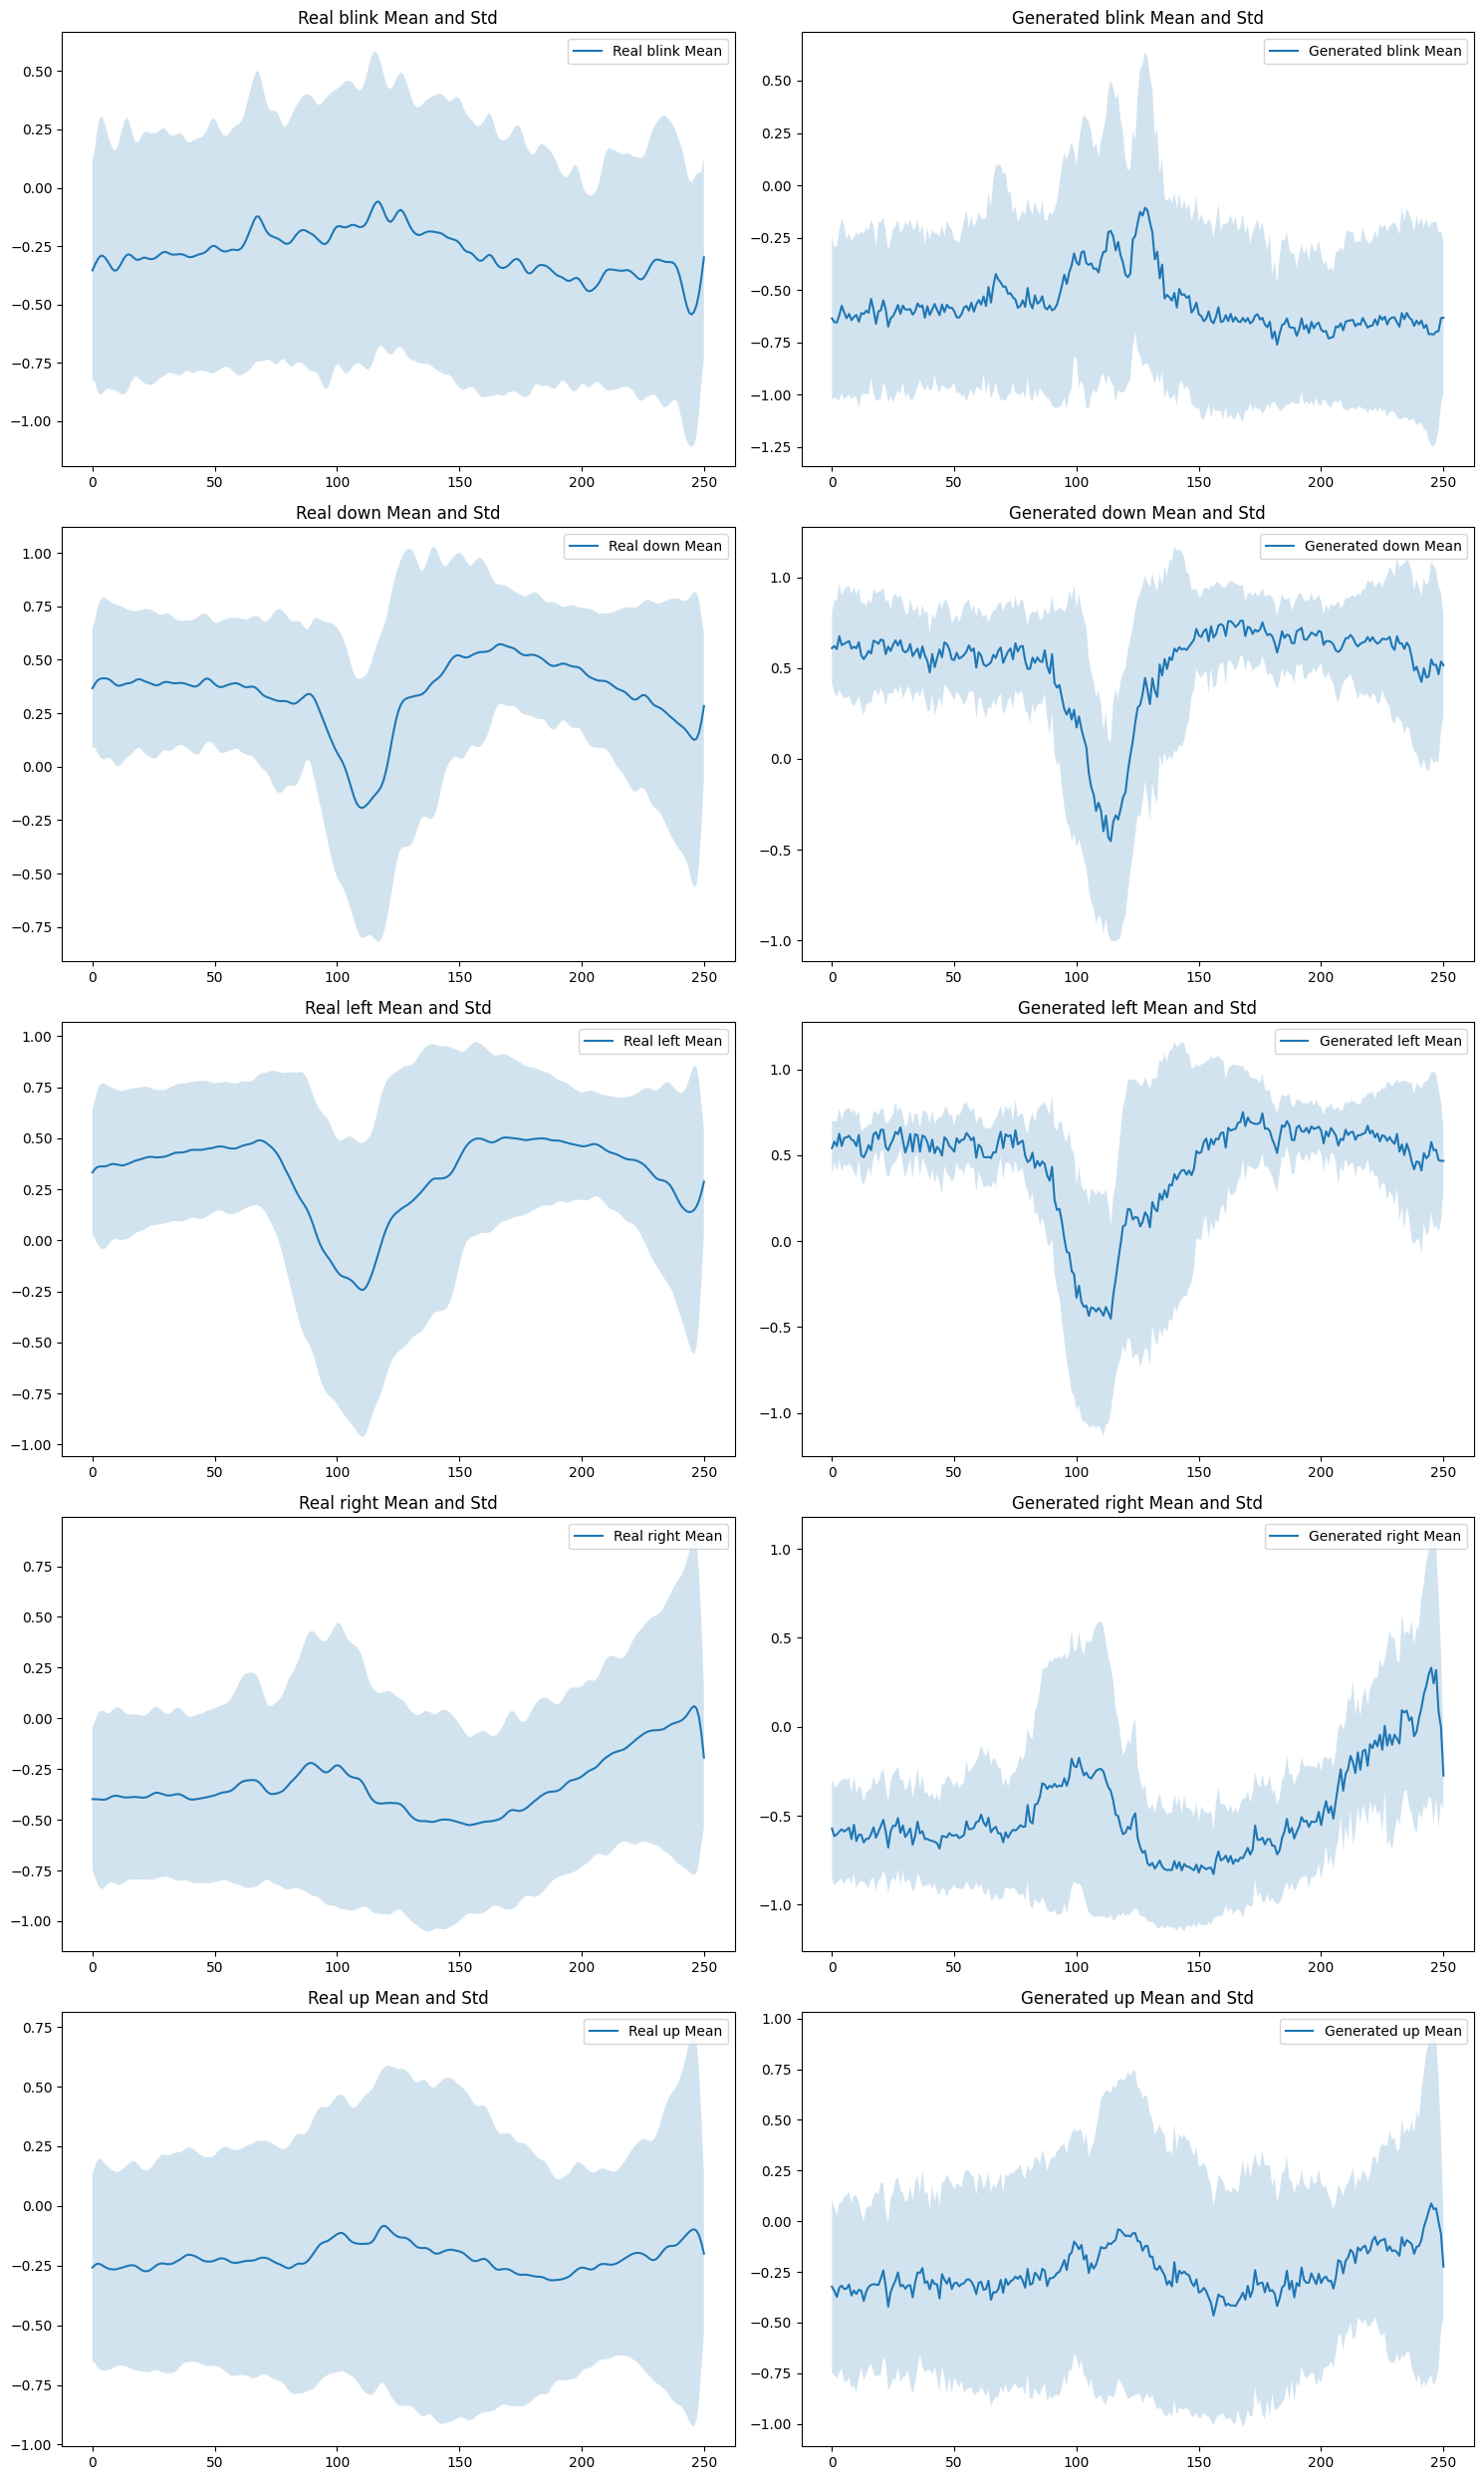

In [31]:
num_samples = 100  # Use a larger number for smoother mean/std

plt.figure(figsize=(15, 5 * len(le.classes_)))
for i, label_name in enumerate(le.classes_):
    label_idx = le.transform([label_name])[0]
    real_signals_class = processed_data[label_encoded == label_idx]
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    gen_labels = np.full((num_samples, 1), label_idx)
    generated_signals_class = generator.predict([noise, gen_labels])
    if generated_signals_class.size == 0 or real_signals_class.shape[0] == 0:
        print(f"Skipping label {label_name} due to no samples")
        continue
    real_mean = np.mean(real_signals_class, axis=0)
    real_std = np.std(real_signals_class, axis=0)
    generated_mean = np.mean(generated_signals_class, axis=0)
    generated_std = np.std(generated_signals_class, axis=0)
    plt.subplot(len(le.classes_), 2, 2 * i + 1)
    plt.plot(real_mean, label=f"Real {label_name} Mean")
    plt.fill_between(np.arange(real_mean.size), real_mean - real_std,
                     real_mean + real_std, alpha=0.2)
    plt.title(f"Real {label_name} Mean and Std")
    plt.legend()
    plt.subplot(len(le.classes_), 2, 2 * i + 2)
    plt.plot(generated_mean, label=f"Generated {label_name} Mean")
    plt.fill_between(np.arange(generated_mean.size), generated_mean - generated_std,
                     generated_mean + generated_std, alpha=0.2)
    plt.title(f"Generated {label_name} Mean and Std")
    plt.legend()
plt.tight_layout()
plt.show()

**Plot mean and std for real and generated signals per class**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


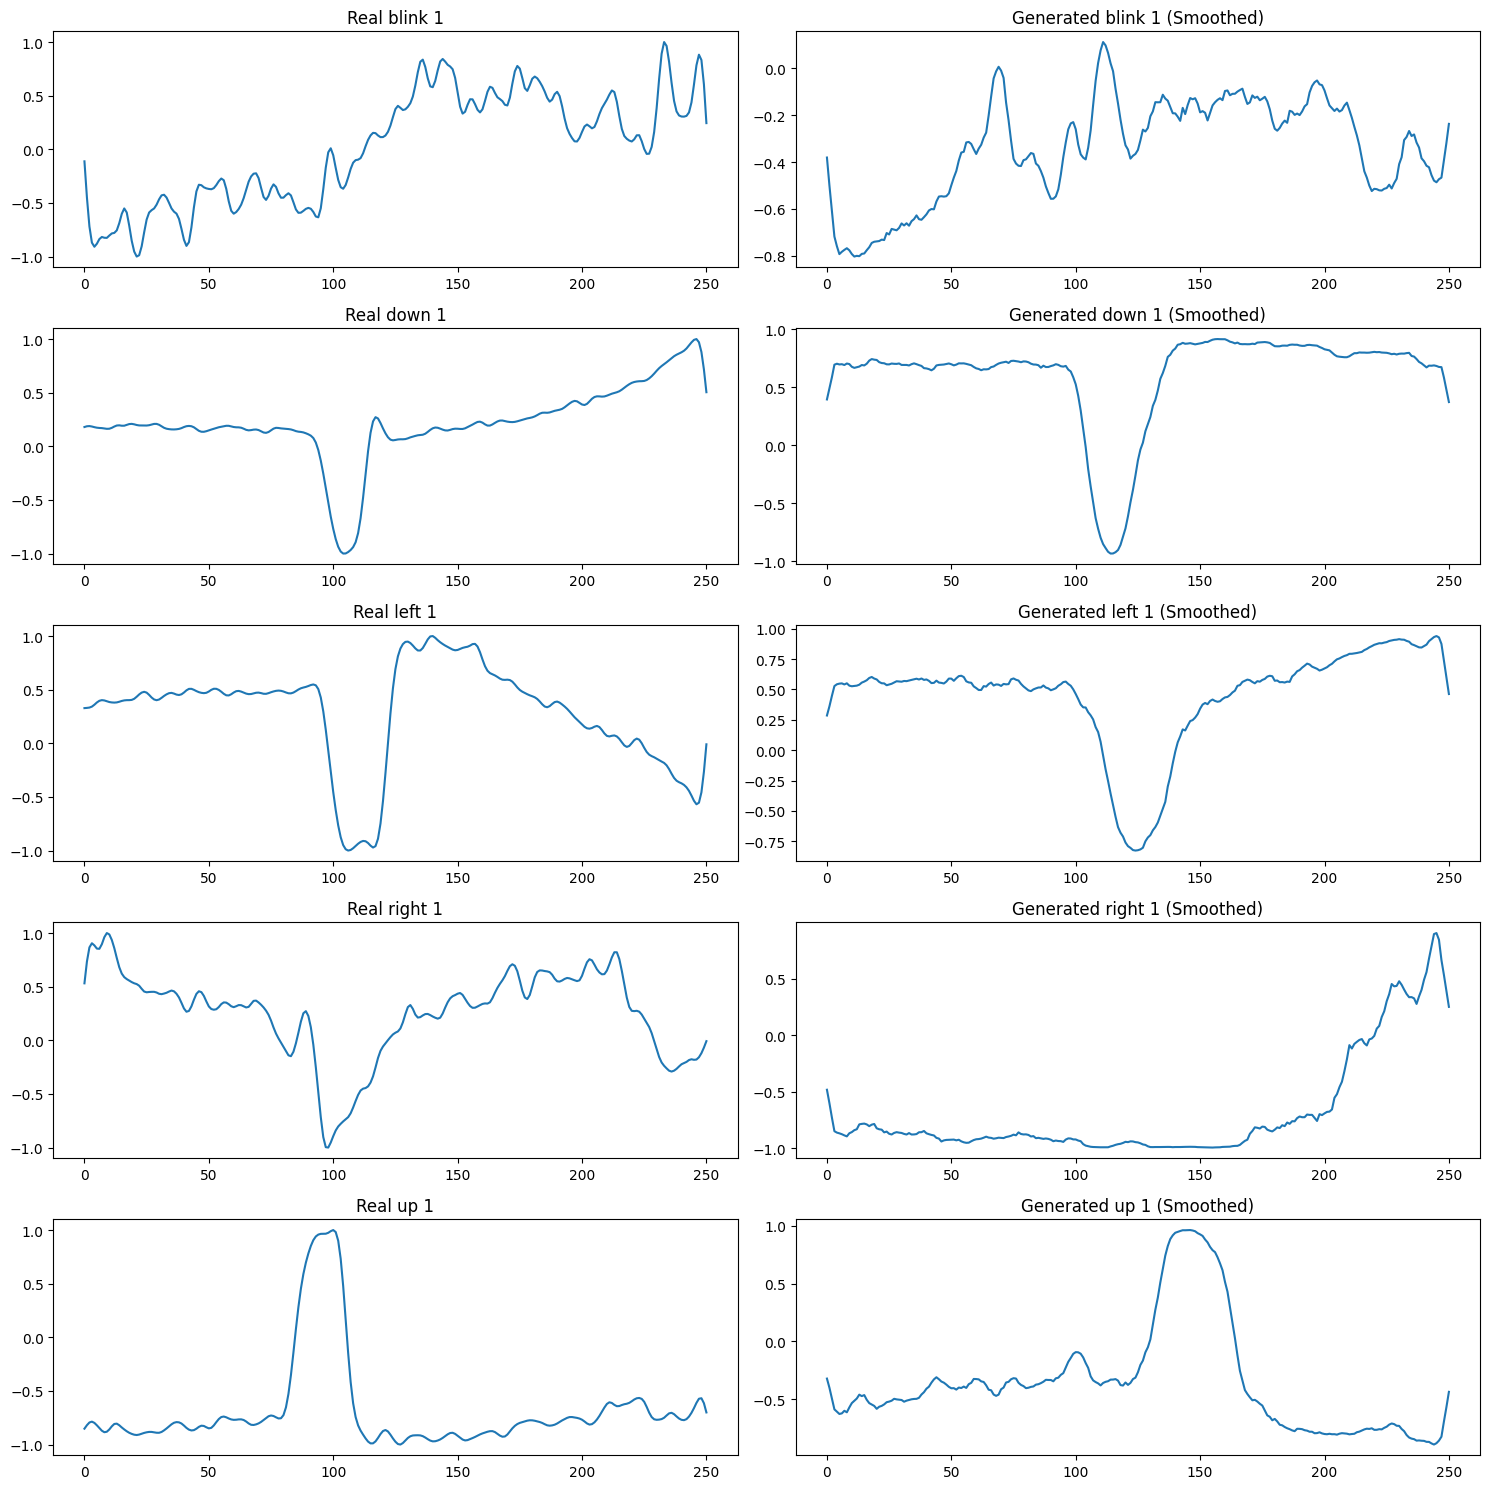

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_signal(signal, window_size=7):
    """Smooth the signal using a moving average filter."""
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

num_samples = 1  # Set as needed

plt.figure(figsize=(15, 3 * len(le.classes_) * num_samples))
for i, label_name in enumerate(le.classes_):
    label_idx = le.transform([label_name])[0]
    real_indices = np.where(label_encoded == label_idx)[0]
    num_real_samples = len(real_indices)
    # Generate signals for this class
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    gen_labels = np.full((num_samples, 1), label_idx)
    generated_signals_class = generator.predict([noise, gen_labels])
    for j in range(num_samples):
        # Plot real signal (if available)
        plt.subplot(len(le.classes_), 2 * num_samples, 2 * j + 1 + i * 2 * num_samples)
        if j < num_real_samples:
            plt.plot(processed_data[real_indices[j]])
            plt.title(f"Real {label_name} {j + 1}")
        else:
            plt.plot(np.zeros_like(processed_data[0]))
            plt.title(f"Real {label_name} {j + 1} (No Data)")
        # Plot smoothed generated signal
        plt.subplot(len(le.classes_), 2 * num_samples, 2 * j + 2 + i * 2 * num_samples)
        plt.plot(smooth_signal(generated_signals_class[j]))
        plt.title(f"Generated {label_name} {j + 1} (Smoothed)")
plt.tight_layout()
plt.show()

**FFT comparison for each class**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


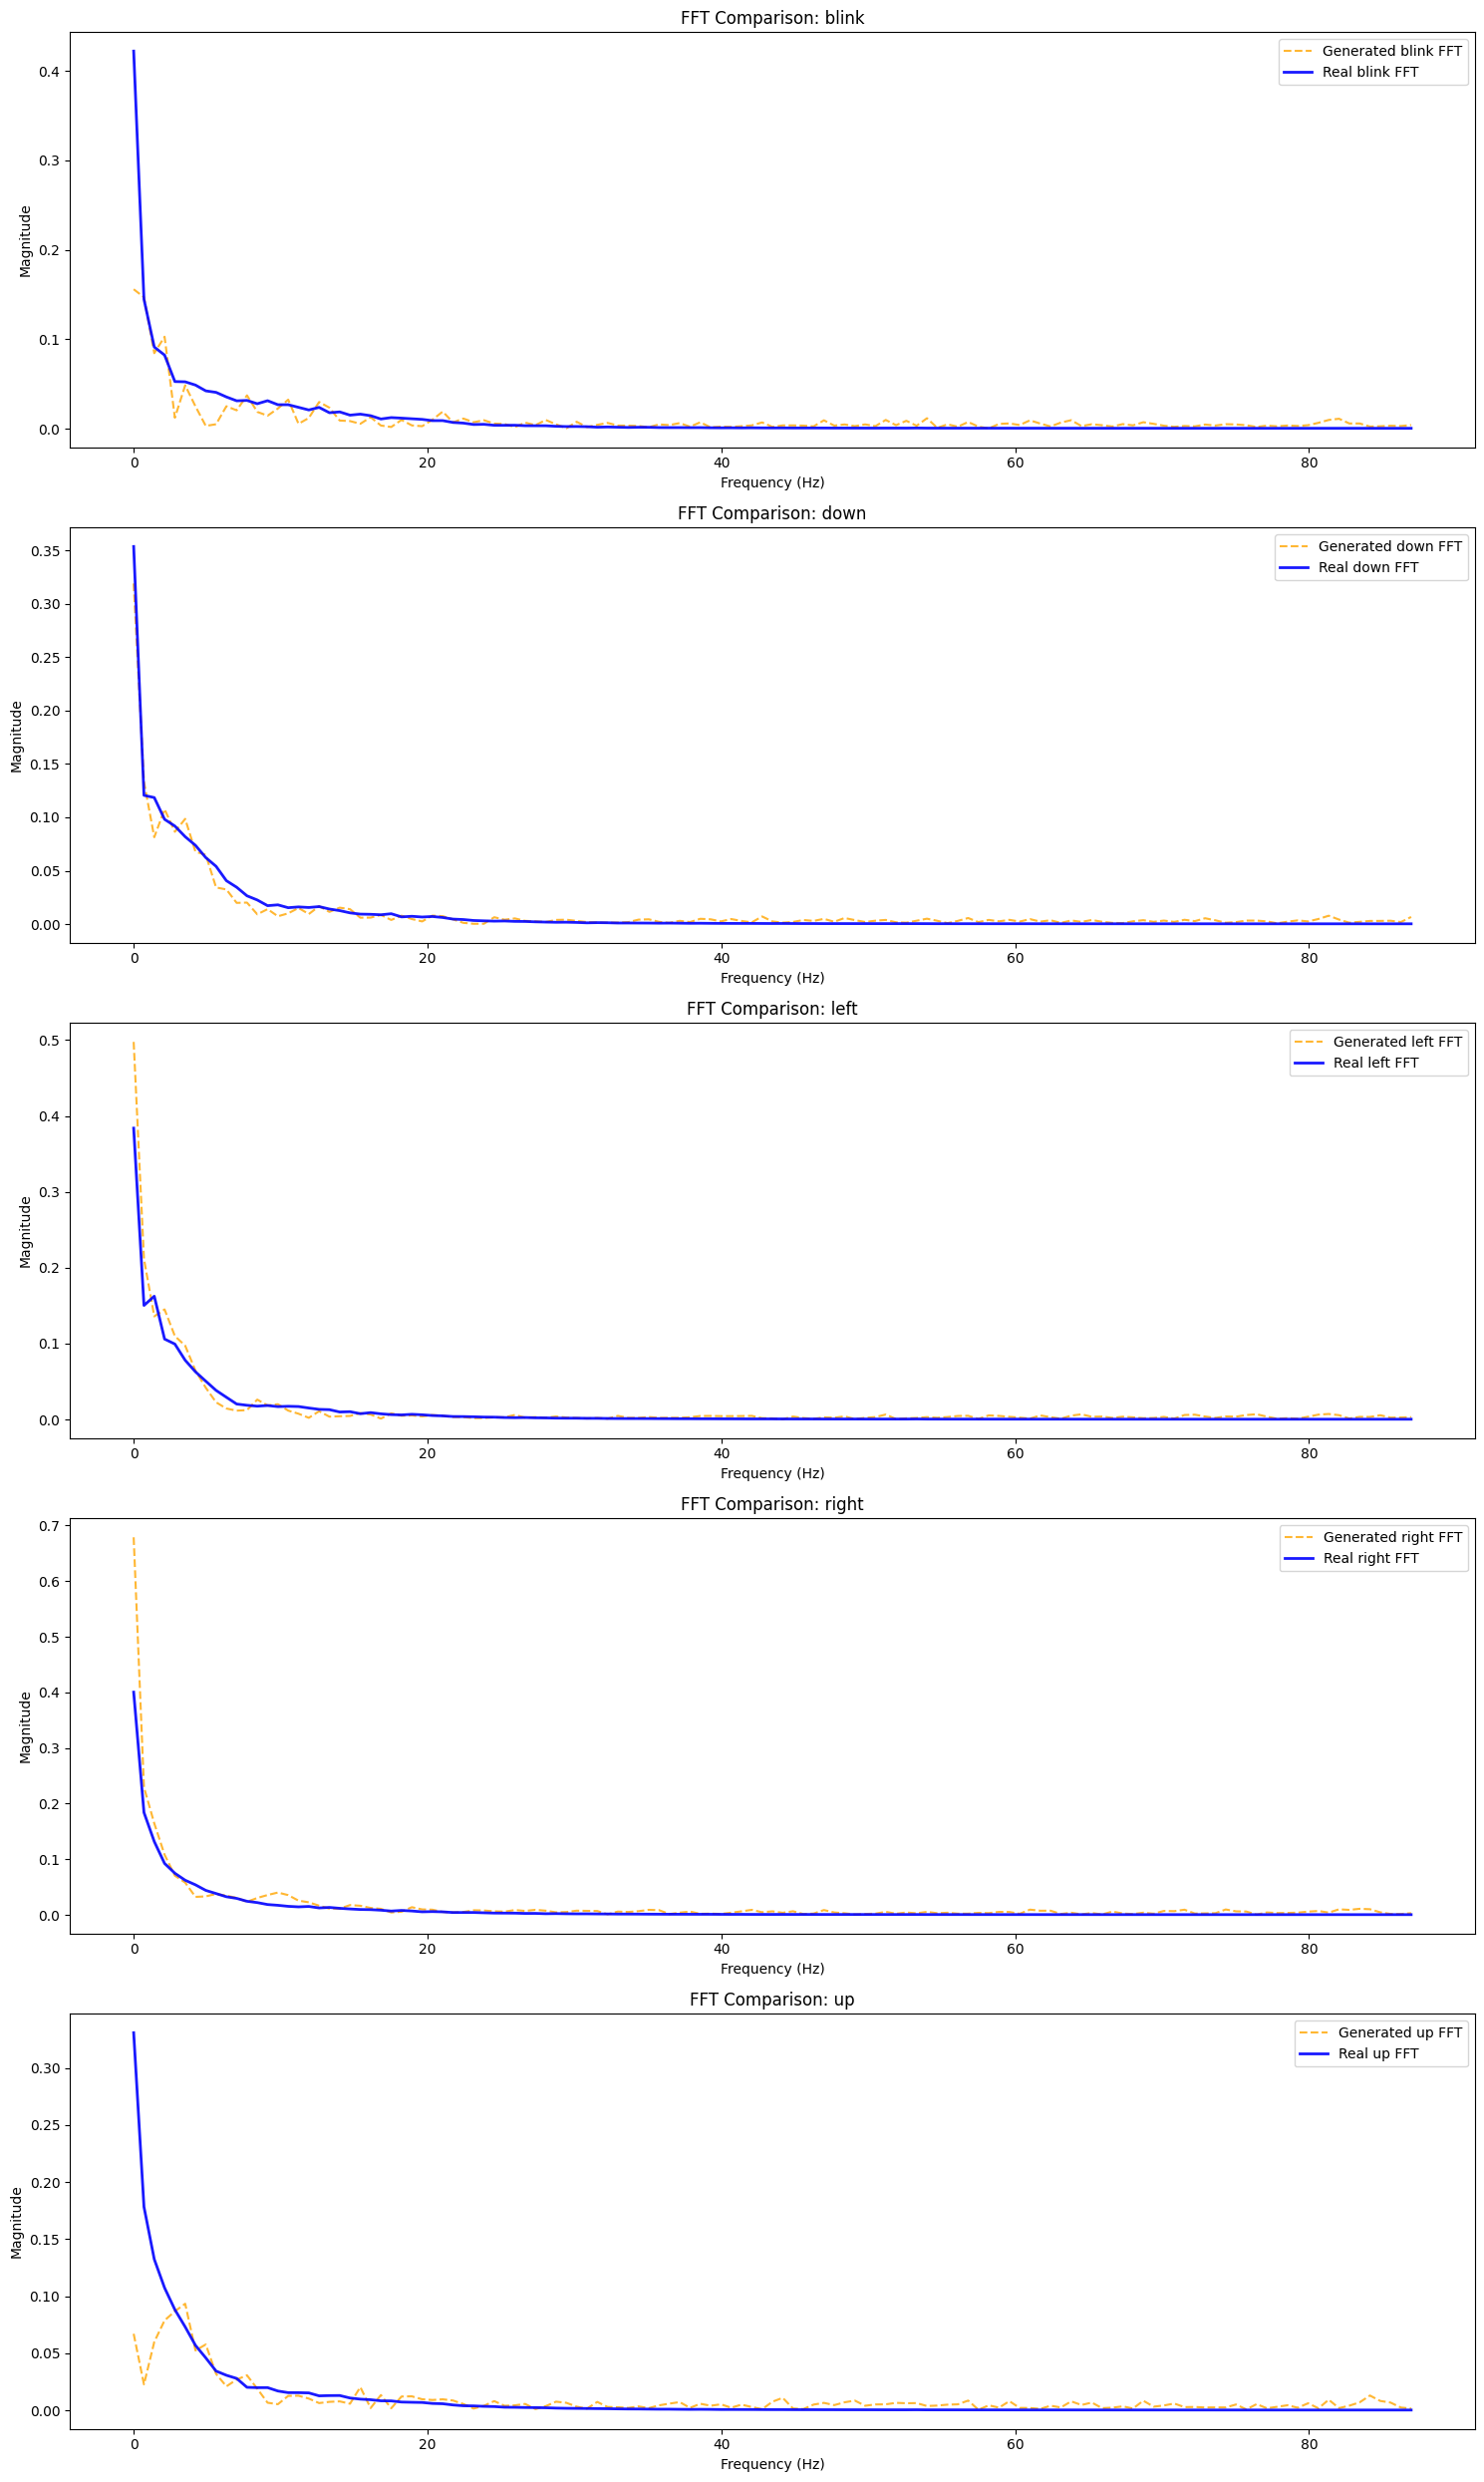

In [24]:
def calculate_fft(signal, fs):
    n = len(signal)
    k = np.arange(n)
    T = n / fs
    frq = k / T
    frq = frq[range(n // 2)]
    Y = np.fft.fft(signal) / n
    Y = Y[range(n // 2)]
    return frq, np.abs(Y)


plt.figure(figsize=(15, 5 * len(le.classes_)))
for i, label_name in enumerate(le.classes_):
    label_idx = le.transform([label_name])[0]
    # FIX: Use label_encoded for correct indexing
    real_signals_class = processed_data[label_encoded == label_idx]
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    gen_labels = np.full((num_samples, 1), label_idx)
    generated_signals_class = generator.predict([noise, gen_labels])
    if generated_signals_class.size == 0 or real_signals_class.shape[0] == 0:
        print(f"Skipping label {label_name} due to no samples")
        continue
    real_fft_mean = np.zeros(real_signals_class.shape[1] // 2)
    generated_fft_mean = np.zeros(generated_signals_class.shape[1] // 2)
    for real_signal in real_signals_class:
        frq, Y = calculate_fft(real_signal, fs)
        real_fft_mean += Y
    real_fft_mean /= real_signals_class.shape[0]
    for generated_signal in generated_signals_class:
        frq, Y = calculate_fft(generated_signal, fs)
        generated_fft_mean += Y
    generated_fft_mean /= generated_signals_class.shape[0]
    plt.subplot(len(le.classes_), 1, i + 1)
    plt.plot(frq, generated_fft_mean, label=f"Generated {label_name} FFT", color='orange', linestyle='--', alpha=0.8)
    plt.plot(frq, real_fft_mean, label=f"Real {label_name} FFT", color='blue', linestyle='-', linewidth=2, alpha=0.9)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(f"FFT Comparison: {label_name}")
    plt.legend()
plt.tight_layout()
plt.show()

**tSNE Visualization**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


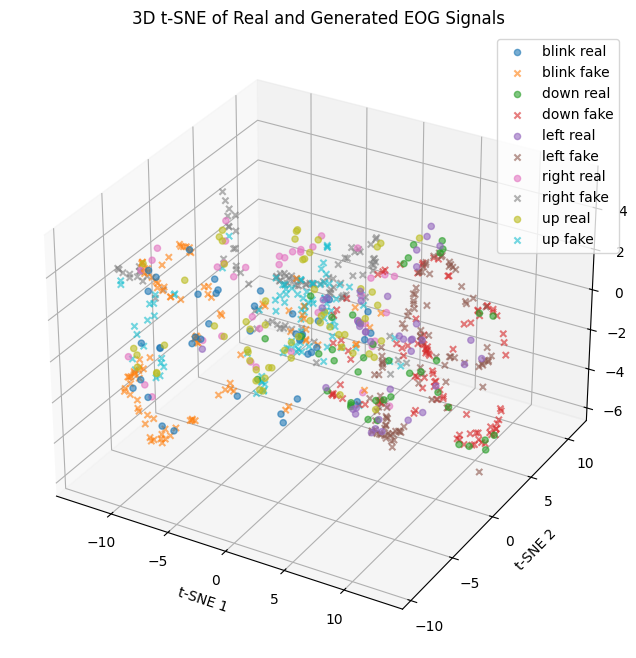

In [57]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

all_signals = []
all_labels = []
all_types = []
num_per_label = 100

for label_name in le.classes_:
    label_idx = le.transform([label_name])[0]
    real_idx = np.where(label_encoded == label_idx)[0]
    real_samples = processed_data[real_idx[:num_per_label]]
    all_signals.append(real_samples)
    all_labels += [label_name] * len(real_samples)
    all_types += ['real'] * len(real_samples)
    noise = np.random.normal(0, 1, (num_per_label, latent_dim))
    gen_labels = np.full((num_per_label, 1), label_idx)
    fake_samples = generator.predict([noise, gen_labels])
    all_signals.append(fake_samples)
    all_labels += [label_name] * len(fake_samples)
    all_types += ['fake'] * len(fake_samples)

all_signals = np.vstack(all_signals)
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
embeddings = tsne.fit_transform(all_signals)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for label in le.classes_:
    for typ, marker in zip(['real', 'fake'], ['o', 'x']):
        idx = [i for i, (l, t) in enumerate(zip(all_labels, all_types)) if l == label and t == typ]
        ax.scatter(embeddings[idx, 0], embeddings[idx, 1], embeddings[idx, 2],
                   label=f"{label} {typ}", alpha=0.6, marker=marker)
ax.set_title("3D t-SNE of Real and Generated EOG Signals")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.legend()
plt.show()

**Plot Training Loss**

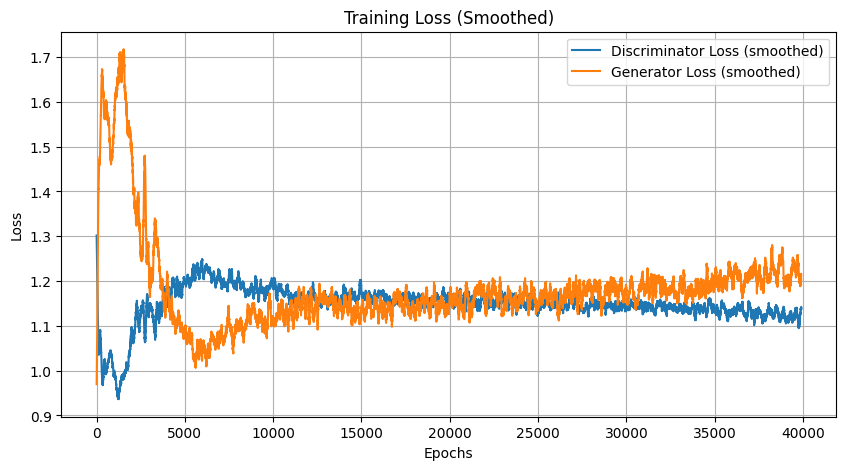

In [58]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 100  # Adjust for more/less smoothing

d_loss_smooth = moving_average(training_history['d_loss'], window_size)
g_loss_smooth = moving_average(training_history['g_loss'], window_size)

plt.figure(figsize=(10, 5))
plt.plot(d_loss_smooth, label='Discriminator Loss (smoothed)')
plt.plot(g_loss_smooth, label='Generator Loss (smoothed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()

**Signal similarity metrics (MSE, DTW, Cross-correlation) and **FID calculation****

In [27]:
from dtw import dtw
from scipy.linalg import sqrtm

num_samples = 100  # Number of generated samples per class for evaluation

mse_list = []
dtw_list = []
cross_corr_list = []
all_real = []
all_fake = []

for i, label_name in enumerate(le.classes_):
    label_idx = le.transform([label_name])[0]
    real_signals_class = processed_data[label_encoded == label_idx]
    # Use the same number of real samples as generated
    real_subset = real_signals_class[:num_samples]
    # Generate signals for this class
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    gen_labels = np.full((num_samples, 1), label_idx)
    generated_signals_class = generator.predict([noise, gen_labels])
    all_real.append(real_subset)
    all_fake.append(generated_signals_class)
    # For each generated signal, find the closest real signal (best match)
    for generated_signal in generated_signals_class:
        mses = [np.mean((real_signal - generated_signal) ** 2) for real_signal in real_subset]
        dtws = [dtw(real_signal, generated_signal).distance for real_signal in real_subset]
        corrs = [np.corrcoef(real_signal, generated_signal)[0, 1] for real_signal in real_subset]
        mse_list.append(np.min(mses))
        dtw_list.append(np.min(dtws))
        cross_corr_list.append(np.max(corrs))

print("Best-case MSE mean:", np.mean(mse_list))
print("Best-case DTW mean:", np.mean(dtw_list))
print("Best-case Cross-correlation mean:", np.mean(cross_corr_list))

# FID calculation (class-balanced, same number of samples)
def calculate_statistics(signals):
    mu = np.mean(signals, axis=0)
    sigma = np.cov(signals, rowvar=False)
    return mu, sigma

all_real = np.vstack(all_real)
all_fake = np.vstack(all_fake)
mu1, sigma1 = calculate_statistics(all_real)
mu2, sigma2 = calculate_statistics(all_fake)
ssdiff = np.sum((mu1 - mu2) ** 2.0)
covmean = sqrtm(sigma1.dot(sigma2))
if np.iscomplexobj(covmean):
    covmean = covmean.real
fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
print("FID:", fid)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Best-case MSE mean: 0.04742198191643446
Best-case DTW mean: 19.81720269025181
Best-case Cross-correlation mean: 0.8959497696940056
FID: 7.258919866132472


**Confusion Matrix**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━

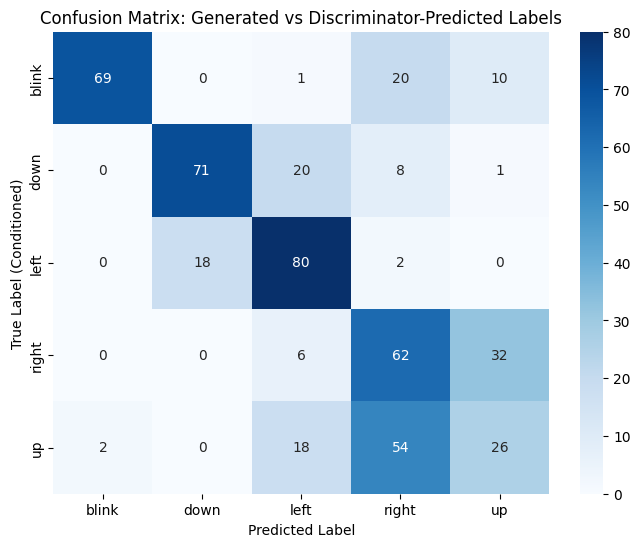

In [60]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

num_samples_per_class = 100  # or any number you want for each class

generated_signals = []
generated_labels_true = []

for i in range(num_classes):
    noise = np.random.normal(0, 1, (num_samples_per_class, latent_dim))
    labels_for_gen = np.full((num_samples_per_class, 1), i)
    generated_signals_batch = generator.predict([noise, labels_for_gen])
    generated_signals.append(generated_signals_batch)
    generated_labels_true.extend([i] * num_samples_per_class)

generated_signals = np.vstack(generated_signals)
generated_labels_true = np.array(generated_labels_true)

predicted_labels = []
for sig, true_label in zip(generated_signals, generated_labels_true):
    scores = []
    for class_idx in range(num_classes):
        score = discriminator.predict([sig.reshape(1, -1), np.array([[class_idx]])])[0][0]
        scores.append(score)
    predicted_label = np.argmax(scores)
    predicted_labels.append(predicted_label)
predicted_labels = np.array(predicted_labels)

cm = confusion_matrix(generated_labels_true, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label (Conditioned)')
plt.title("Confusion Matrix: Generated vs Discriminator-Predicted Labels")
plt.show()

In [61]:
from sklearn.metrics import classification_report, accuracy_score

# Print classification report
print("Classification Report:")
print(classification_report(generated_labels_true, predicted_labels, target_names=le.classes_))

# Print overall accuracy
acc = accuracy_score(generated_labels_true, predicted_labels)
print(f"Overall Accuracy: {acc:.4f}")

Classification Report:
              precision    recall  f1-score   support

       blink       0.97      0.69      0.81       100
        down       0.80      0.71      0.75       100
        left       0.64      0.80      0.71       100
       right       0.42      0.62      0.50       100
          up       0.38      0.26      0.31       100

    accuracy                           0.62       500
   macro avg       0.64      0.62      0.62       500
weighted avg       0.64      0.62      0.62       500

Overall Accuracy: 0.6160


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


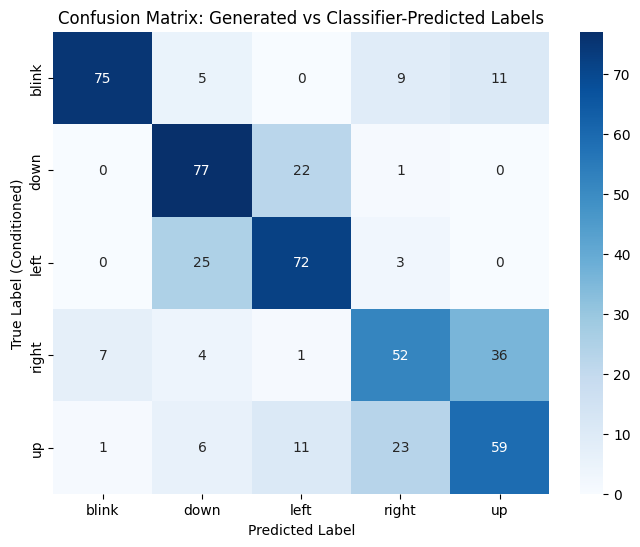

Classification Report:
              precision    recall  f1-score   support

       blink       0.90      0.75      0.82       100
        down       0.66      0.77      0.71       100
        left       0.68      0.72      0.70       100
       right       0.59      0.52      0.55       100
          up       0.56      0.59      0.57       100

    accuracy                           0.67       500
   macro avg       0.68      0.67      0.67       500
weighted avg       0.68      0.67      0.67       500

Overall Accuracy: 0.6700


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Train classifier on real data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(processed_data, label_encoded)

# 2. Generate signals for each class
num_samples_per_class = 100
generated_signals = []
generated_labels_true = []

for i in range(num_classes):
    noise = np.random.normal(0, 1, (num_samples_per_class, latent_dim))
    labels_for_gen = np.full((num_samples_per_class, 1), i)
    generated_signals_batch = generator.predict([noise, labels_for_gen])
    generated_signals.append(generated_signals_batch)
    generated_labels_true.extend([i] * num_samples_per_class)

generated_signals = np.vstack(generated_signals)
generated_labels_true = np.array(generated_labels_true)

# 3. Predict using the classifier
predicted_labels = clf.predict(generated_signals)

# 4. Confusion matrix and report
cm = confusion_matrix(generated_labels_true, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label (Conditioned)')
plt.title("Confusion Matrix: Generated vs Classifier-Predicted Labels")
plt.show()

print("Classification Report:")
print(classification_report(generated_labels_true, predicted_labels, target_names=le.classes_))
print(f"Overall Accuracy: {accuracy_score(generated_labels_true, predicted_labels):.4f}")

**Save The Model**

In [ ]:
# -- Save Generator for TensorFlow.js ---

import tensorflowjs as tfjs
tfjs.converters.save_keras_model(generator, 'tfjs_generator_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [20]:
# --- Save the Generator in .h5 Format ---
generator.save('generator_model.h5')
print("Generator saved in generator_model.h5")

Generator saved in generator_model.h5


**Generate and Plot Multiple Samples Per Label**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


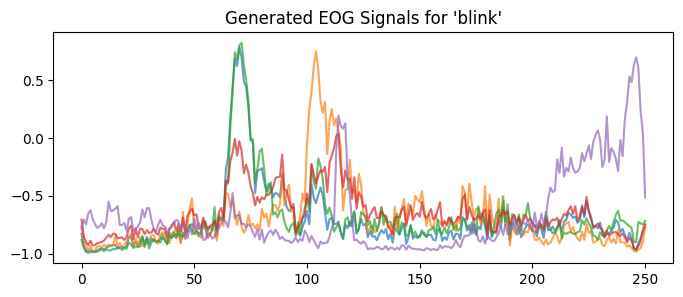

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


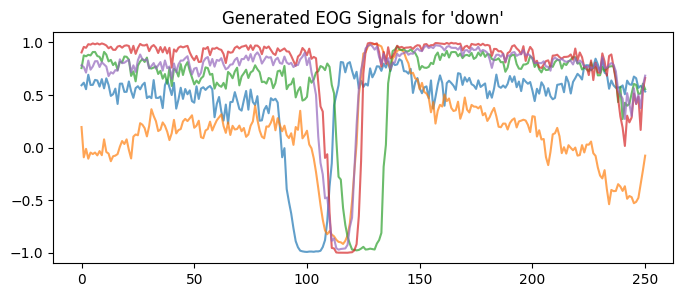

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


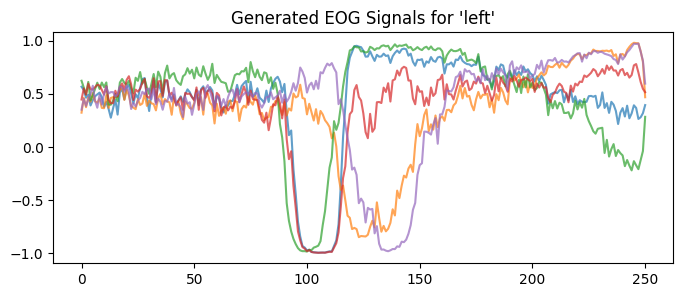

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


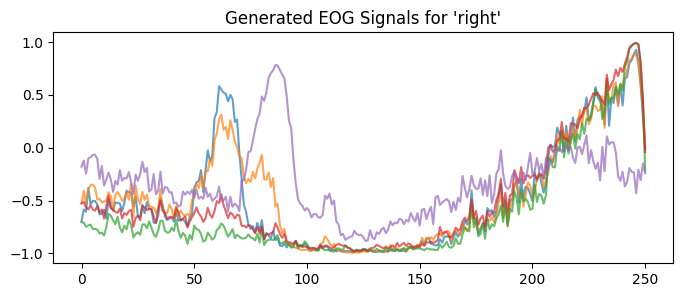

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


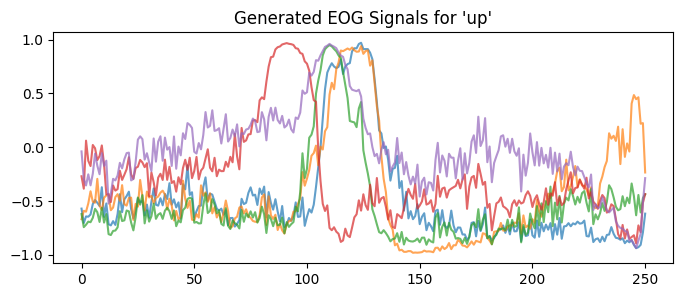

In [21]:
# -- Generate and Plot Multiple Samples Per Label ---

def generate_sample(generator, label_name, latent_dim=100):
    label_idx = le.transform([label_name])[0]
    noise = np.random.normal(0, 1, (1, latent_dim))
    gen_signal = generator.predict([noise, np.array([[label_idx]])])
    return gen_signal.flatten()

for label in le.classes_:
    plt.figure(figsize=(8, 3))
    for _ in range(5):
        plt.plot(generate_sample(generator, label), alpha=0.7)
    plt.title(f"Generated EOG Signals for '{label}'")
    plt.show()

**Perfromance testing of model**

In [22]:

#Preprocessed the data before testing the model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.signal import butter, filtfilt

folder_path = 'class/3-class'

def map_filename_to_label(name):
    name_low = name.casefold()
    if "yukar" in name_low:
        return "up"
    elif "asagi" in name_low:
        return "down"
    elif "sag" in name_low:
        return "right"
    elif "sol" in name_low:
        return "left"
    elif "kirp" in name_low:
        return "blink"
    else:
        return None

files = [f for f in glob.glob(folder_path + '/*.txt')
         if all(x not in f.lower() for x in ['örnek', 'edit', 'serkan', 'kayit'])]

data_list = []
labels = []

for f in files:
    label = map_filename_to_label(f)
    if label is None:
        continue
    signal = np.loadtxt(f)
    if len(signal.shape) > 1:
        signal = signal.flatten()
    data_list.append(signal)
    labels.append(label)

data_array = np.array(data_list)
labels = np.array(labels)

def butter_bandpass_filter(signal, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

fs = 176  

def preprocess_signal(signal):
    filtered = butter_bandpass_filter(signal, 0.5, 20.0, fs, order=2)
    filtered = filtered - np.mean(filtered)  # Remove DC offset
    scaler = MinMaxScaler(feature_range=(-1, 1))
    filtered = scaler.fit_transform(filtered.reshape(-1, 1)).flatten()
    return filtered

processed_data = np.array([preprocess_signal(sig) for sig in data_array])
le = LabelEncoder()
label_encoded = le.fit_transform(labels)
label_classes = list(le.classes_)
signal_length = processed_data.shape[1]
num_classes = len(label_classes)
latent_dim = 100

print(f"Loaded {len(processed_data)} preprocessed signals with labels: {label_classes}")



Loaded 223 preprocessed signals with labels: ['blink', 'down', 'left', 'right', 'up']


Generator model loaded from generator_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


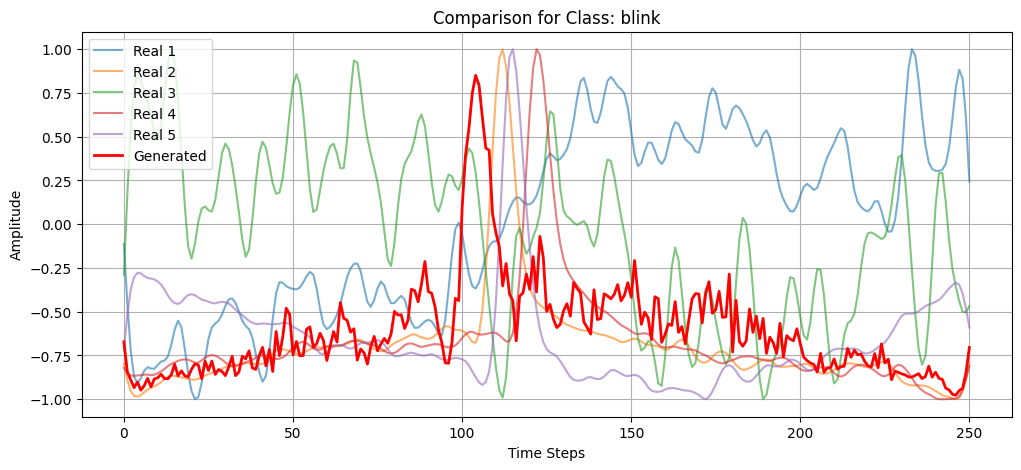

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


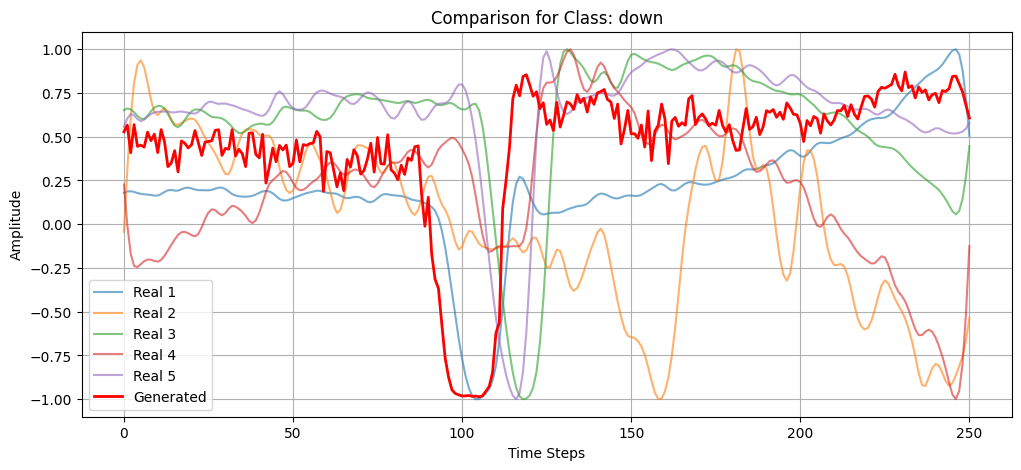

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


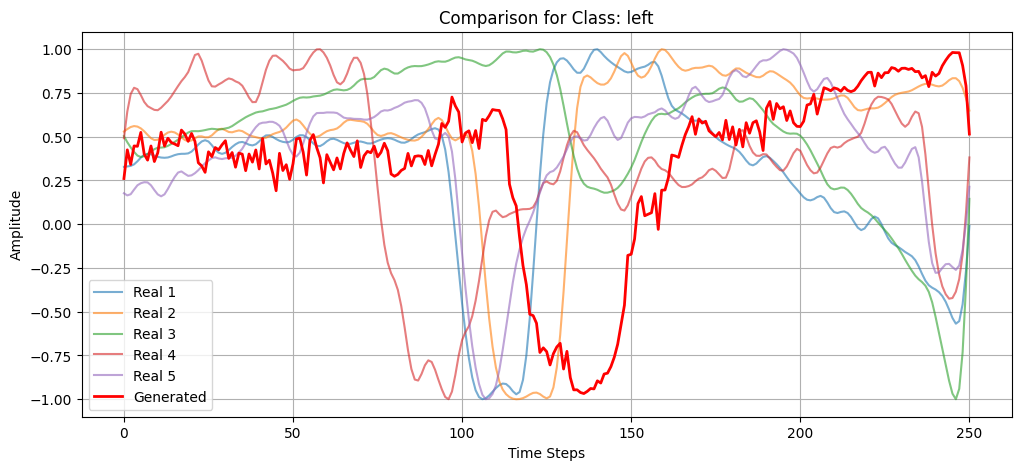

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


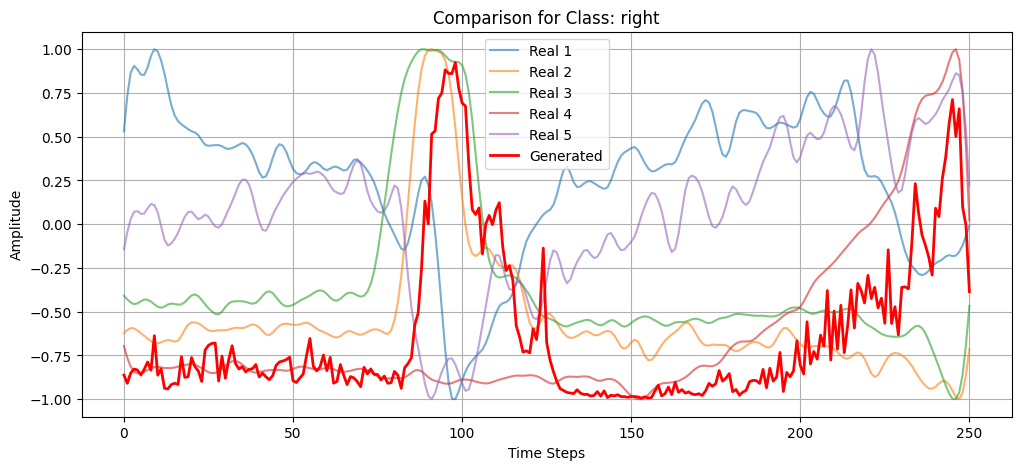

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


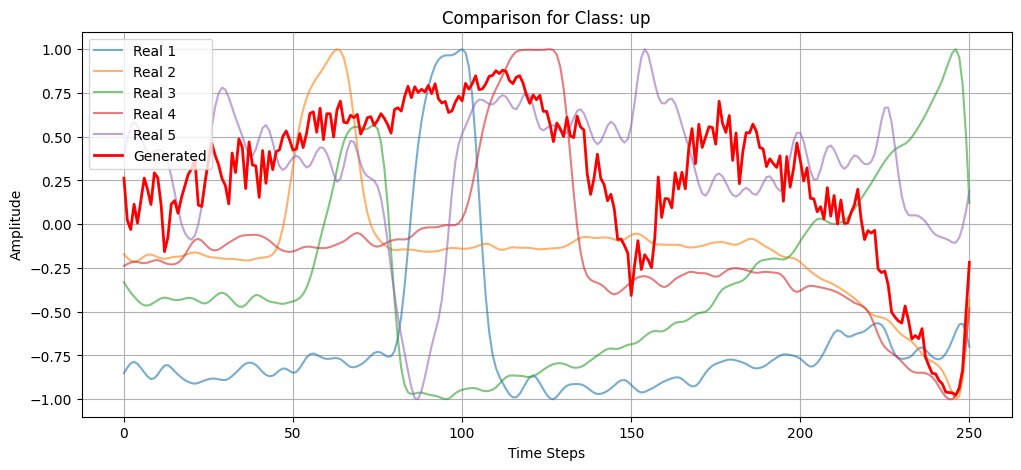

In [23]:
# - Load the Saved Generator (.h5 format) ---
generator = tf.keras.models.load_model('generator_model.h5')
print("Generator model loaded from generator_model.h5")

def generate_sample(generator, label_index, latent_dim=100):
    noise = np.random.normal(0, 1, (1, latent_dim))
    label_input = np.array([[label_index]])
    generated_signal = generator.predict([noise, label_input])
    return generated_signal.flatten()

def plot_comparison(real_signals, generated_signal, title):
    plt.figure(figsize=(12, 5))
    for i, real_sig in enumerate(real_signals):
        plt.plot(real_sig, label=f'Real {i+1}', alpha=0.6)
    plt.plot(generated_signal, label='Generated', color='red', linewidth=2)
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

num_samples_to_compare = 5

for i, label in enumerate(label_classes):
    # Get indices of real samples for the current class
    real_indices = np.where(labels == label)[0]
    if len(real_indices) >= num_samples_to_compare:
        selected_real_signals = processed_data[real_indices[:num_samples_to_compare]]

        # Generate a signal for the current class
        generated_signal = generate_sample(generator, i, latent_dim)

        # Plot the comparison
        plot_comparison(selected_real_signals, generated_signal, f"Comparison for Class: {label}")
    else:
        print(f"Not enough real samples for class '{label}' to compare.")